# PySpark

Script was run on the TU Wien LBD cluster with the following  hardware setup:
    two XeonE5-2650v4 CPUs with 24 cores (total of 48 cores per node, 864 total worker cores)
    256GB RAM (total of 4.5TB memory available to worker nodes of the whole cluster)
    four hard disks, each with a capacity of 4TB (total of 16TB per node, 288TB total for worker nodes)

It contains code to create samples as well as visualizations of the dataset.

In [1]:
# PySpark import
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyarrow.parquet as pq # https://sparkbyexamples.com/spark/spark-read-write-dataframe-parquet-example/
from pyspark.sql.functions import udf, to_date
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf


In [2]:
# Other imports
import os
import torch
import importlib.util
import numpy as np
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

I0324 11:38:33.608275 139730784212800 file_utils.py:41] PyTorch version 1.0.1.post2 available.


In [3]:
# change the second argument below for more memory
conf = (SparkConf().set("spark.driver.maxResultSize", "2g"))
sc = SparkContext(appName = "master_thesis_1526534", conf = conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.broadcastTimeout", 900)

# change the second part below for more memory
pyspark_submit_args = ' --driver-memory ' + '2g' + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

spark.version

'2.4.0-cdh6.3.2'

## Import Data

In [4]:
# General setings

HDFS_DATAFOLDER = "master_data_hadoop"
#USE_FULL_TRAINING = False

In [5]:
VAL_LABELS = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "enaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager"]
TRAIN_LABELS = VAL_LABELS + ["reply_timestamp" ,"retweet_timestamp" ,"retweet_with_comment_timestamp", "like_timestamp"]

training = spark.read.parquet(os.path.join(HDFS_DATAFOLDER, "training_nh.parquet")).toDF("text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "enaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager", "reply_timestamp" ,"retweet_timestamp" ,"retweet_with_comment_timestamp", "like_timestamp")
val = spark.read.parquet(os.path.join(HDFS_DATAFOLDER, "val_nh.parquet")).toDF("text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "enaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager","reply_timestamp" ,"retweet_timestamp" ,"retweet_with_comment_timestamp", "like_timestamp")
test = spark.read.parquet(os.path.join(HDFS_DATAFOLDER, "test_nh.parquet")).toDF("text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "enaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager","reply_timestamp" ,"retweet_timestamp" ,"retweet_with_comment_timestamp", "like_timestamp")

In [6]:
training

DataFrame[text_tokens: string, hashtags: string, tweet_id: string, present_media: string, present_links: string, present_domains: string, tweet_type: string, language: string, tweet_timestamp: string, enaged_with_user_id: string, engaged_with_user_follower_count: string, engaged_with_user_following_count: string, engaged_with_user_is_verified: string, engaged_with_user_account_creation: string, enaging_user_id: string, enaging_user_follower_count: string, enaging_user_following_count: string, enaging_user_is_verified: string, enaging_user_account_creation: string, engagee_follows_engager: string, reply_timestamp: string, retweet_timestamp: string, retweet_with_comment_timestamp: string, like_timestamp: string]

In [7]:
val

DataFrame[text_tokens: string, hashtags: string, tweet_id: string, present_media: string, present_links: string, present_domains: string, tweet_type: string, language: string, tweet_timestamp: string, enaged_with_user_id: string, engaged_with_user_follower_count: string, engaged_with_user_following_count: string, engaged_with_user_is_verified: string, engaged_with_user_account_creation: string, enaging_user_id: string, enaging_user_follower_count: string, enaging_user_following_count: string, enaging_user_is_verified: string, enaging_user_account_creation: string, engagee_follows_engager: string, reply_timestamp: string, retweet_timestamp: string, retweet_with_comment_timestamp: string, like_timestamp: string]

In [8]:
test

DataFrame[text_tokens: string, hashtags: string, tweet_id: string, present_media: string, present_links: string, present_domains: string, tweet_type: string, language: string, tweet_timestamp: string, enaged_with_user_id: string, engaged_with_user_follower_count: string, engaged_with_user_following_count: string, engaged_with_user_is_verified: string, engaged_with_user_account_creation: string, enaging_user_id: string, enaging_user_follower_count: string, enaging_user_following_count: string, enaging_user_is_verified: string, enaging_user_account_creation: string, engagee_follows_engager: string, reply_timestamp: string, retweet_timestamp: string, retweet_with_comment_timestamp: string, like_timestamp: string]

## Tokenisation

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
model = BertModel.from_pretrained('bert-base-multilingual-cased')
decoder_udf = udf(lambda text_tokens: "".join(tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(text_tokens.split('\t')))), StringType())

def add_decoded_text_column(df):
    df_new = df.withColumn("decoded_text_tokens", decoder_udf(df["text_tokens"]))
    return df_new

add_decoded_text_column(training).select("decoded_text_tokens", "text_tokens")

I0324 11:53:39.582789 139730784212800 tokenization_utils.py:504] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /home/dic20/e1526534/.cache/torch/transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
I0324 11:53:40.226729 139730784212800 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /home/dic20/e1526534/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
I0324 11:53:40.228214 139730784212800 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_star

DataFrame[decoded_text_tokens: string, text_tokens: string]

In [10]:
add_decoded_text_column(val).select("decoded_text_tokens",'like_timestamp','reply_timestamp','retweet_timestamp','retweet_with_comment_timestamp')

DataFrame[decoded_text_tokens: string, like_timestamp: string, reply_timestamp: string, retweet_timestamp: string, retweet_with_comment_timestamp: string]

In [11]:
add_decoded_text_column(test).select("decoded_text_tokens", "text_tokens")

DataFrame[decoded_text_tokens: string, text_tokens: string]

In [12]:
training.schema.names


['text_tokens',
 'hashtags',
 'tweet_id',
 'present_media',
 'present_links',
 'present_domains',
 'tweet_type',
 'language',
 'tweet_timestamp',
 'enaged_with_user_id',
 'engaged_with_user_follower_count',
 'engaged_with_user_following_count',
 'engaged_with_user_is_verified',
 'engaged_with_user_account_creation',
 'enaging_user_id',
 'enaging_user_follower_count',
 'enaging_user_following_count',
 'enaging_user_is_verified',
 'enaging_user_account_creation',
 'engagee_follows_engager',
 'reply_timestamp',
 'retweet_timestamp',
 'retweet_with_comment_timestamp',
 'like_timestamp']

## Sampling


We will create all samples randomly from the full train set.


In [13]:
#NOTE: none of the samples may be combined among each other, 

#sample_2pct=training.sample(withReplacement=False,fraction=0.02,seed=42)
#sample_5pct=training.sample(withReplacement=False,fraction=0.05,seed=42)

trainsample_1pct=training.sample(withReplacement=False,fraction=0.01,seed=42)
trainsample_10pct=training.sample(withReplacement=False,fraction=0.10,seed=42)

valsample_1pct=val.sample(withReplacement=False,fraction=0.01,seed=42)
valsample_10pct=val.sample(withReplacement=False,fraction=0.10,seed=42)

testsample_1pct=test.sample(withReplacement=False,fraction=0.01,seed=42)
testsample_10pct=test.sample(withReplacement=False,fraction=0.10,seed=42)

In [ ]:
#make sure that the sampled dataframe is the right size, 1% is about 1.4 million tweets
print(trainsample_1pct.count(),trainsample_10pct.count())
print(valsample_1pct.count(),valsample_10pct.count())
print(testsample_1pct.count(),testsample_10pct.count())

In [ ]:
#if the size was right, save the dataframe to file

trainsample_1pct.repartition(1).write.format("com.databricks.spark.csv").option('sep','\x01').option('emptyValue',None).option("header", "false").save("sample_1pct.tsv")
#sample_2pct.repartition(1).write.format("com.databricks.spark.csv").option('sep','\x01').option('emptyValue',None).option("header", "false").save("sample_2pct.tsv")
#sample_5pct.repartition(1).write.format("com.databricks.spark.csv").option('sep','\x01').option('emptyValue',None).option("header", "false").save("sample_5pct.tsv")
trainsample_10pct.repartition(1).write.format("com.databricks.spark.csv").option('sep','\x01').option('emptyValue',None).option("header", "false").save("sample_10pct.tsv")

#does not work well as it writes the data in chunks as it is stored on hdfs, this is undesirable as it would have to be merged together manually
#sample_1pct.write.csv('generated_samples/sample_1pct.tsv')
#sample_2pct.write.csv('generated_samples/sample_2pct.tsv')
#sample_5pct.write.csv('generated_samples/sample_5pct.tsv')
#sample_10pct.write.csv('generated_samples/sample_10pct.tsv')
print('Samples saved.')

In [ ]:
#the files created are on hdfs, copy them to disc for them to be downloaded
!hadoop fs -copyToLocal sample_1pct.tsv sample_1pct.tsv
!hadoop fs -copyToLocal sample_2pct.tsv sample_2pct.tsv
!hadoop fs -copyToLocal sample_5pct.tsv sample_5pct.tsv
!hadoop fs -copyToLocal sample_10pct.tsv sample_10pct.tsv


In [ ]:
!ls

In [ ]:
#cleanup hadoop files

#do not clean up if still needed by dataset statistics

#!hadoop fs -rm -r -f sample_1pct.tsv
#!hadoop fs -rm -r -f sample_2pct.tsv
#!hadoop fs -rm -r -f sample_5pct.tsv
#!hadoop fs -rm -r -f sample_10pct.tsv

In [19]:
#clean up local files
#ATTENTION: DO NOT EXECTUTE BEFORE DOWNLOADING FILES
!rm -rf sample_*

In [ ]:
!ls

## Dataset Statistics

Generating visualizations for train
Showing plots for the number of present domains


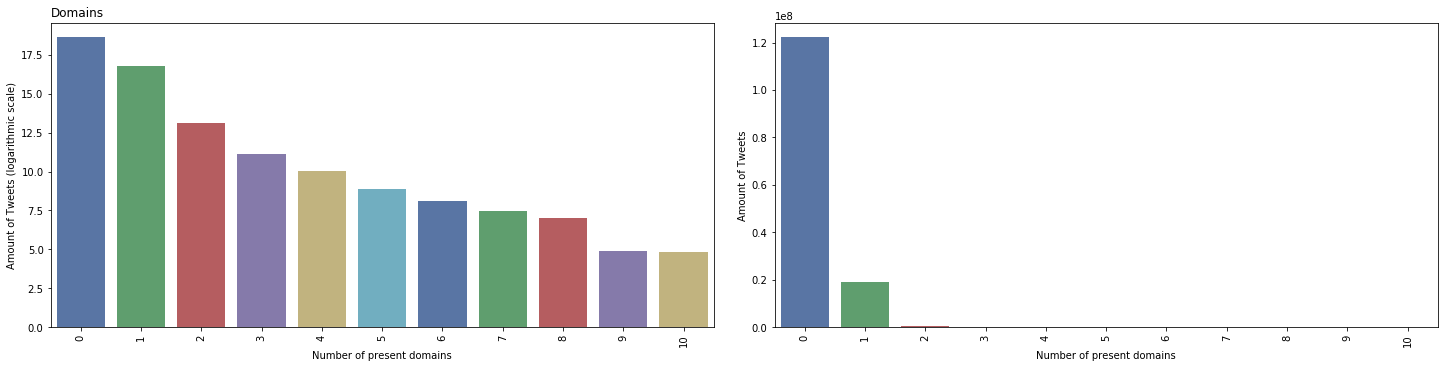

Showing plots for the number of hashtags


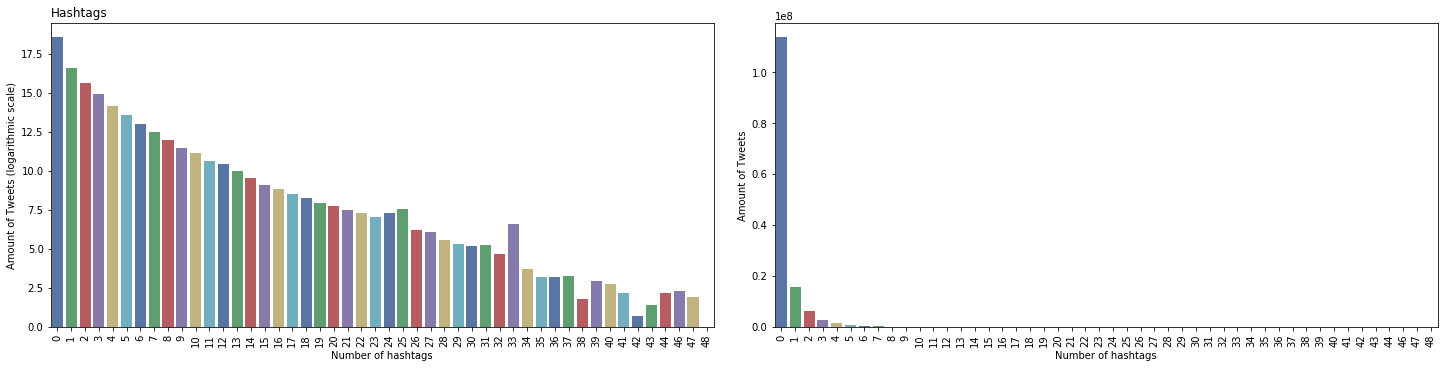

Showing plots for present media:


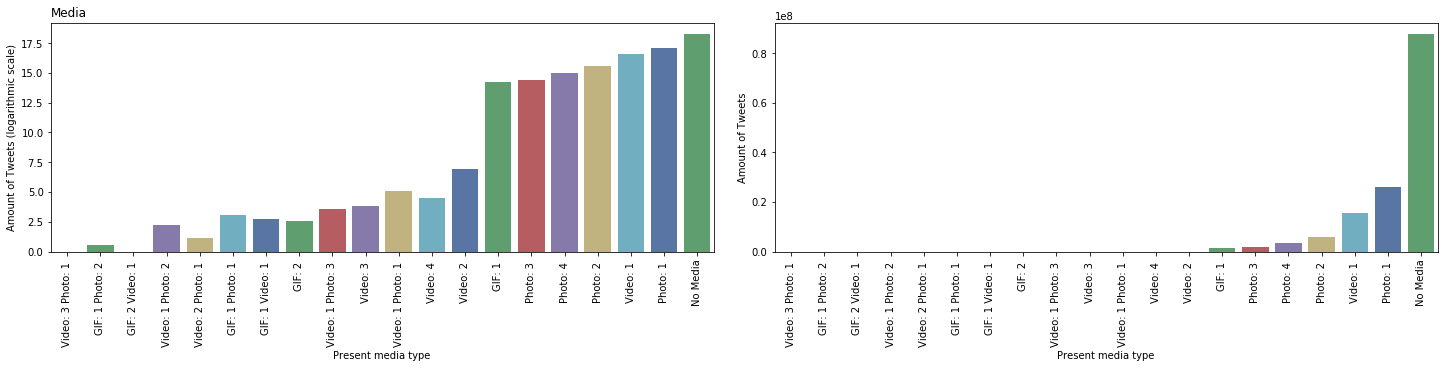

Showing plots for languages:


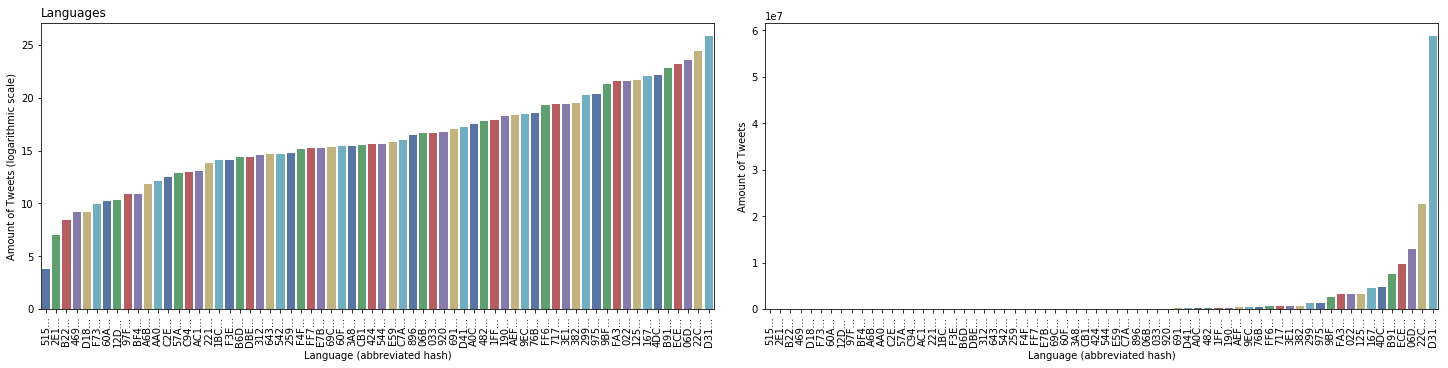

Showing plot for tweet types:
Showing plots for labels:


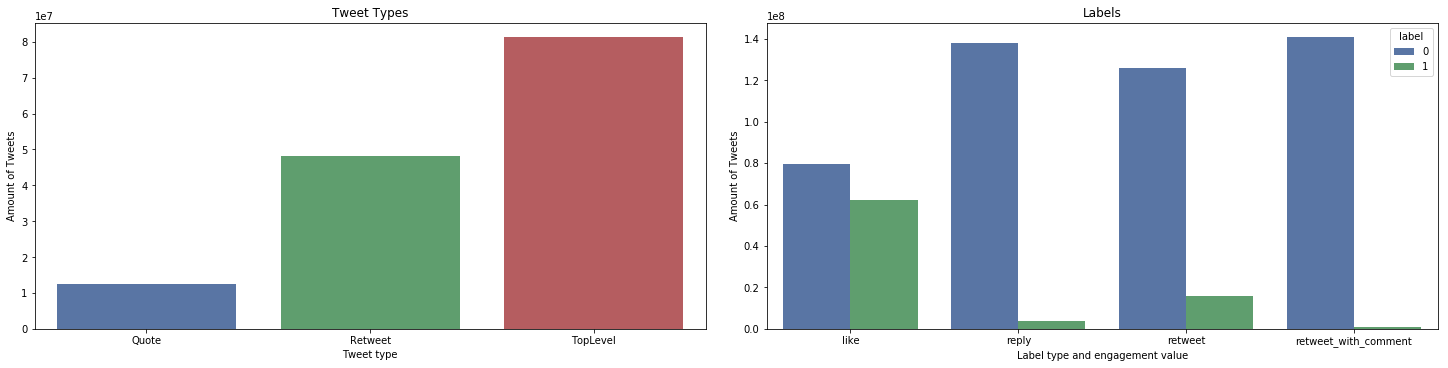

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import io
from PIL import Image

def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return PIL.Image.open(buf)

#sets the figsize for all plots
plt.rcParams["figure.figsize"] = (20,5)

@udf
def count_entries(s):
    if s is not None:
      return len(s.split('\t'))
    else:
      return 0

def convert_number_to_label(number):
    #returns 1 if the respective value is not None and 0 otherwise, used to convert the interaction labels
    if number is not None and number is not np.nan:
        return 1
    else:
        return 0

def count_media_types(s):
    gif_count=s.count('GIF')
    photo_count=s.count('Photo')
    video_count=s.count('Video')
    return_str=''
    if gif_count != 0:
        return_str = return_str + f'GIF: {gif_count} '
    if video_count != 0:
        return_str = return_str + f'Video: {video_count} '
    if photo_count !=0:
        return_str = return_str + f'Photo: {photo_count} '
    if photo_count + video_count + gif_count == 0:
        return_str = 'No Media'
    
    assert return_str != ''
    
    return return_str


    
def compute_dataset_statistics(dataset, dataset_name, palette='deep', color='#000000'):
    """
    will compute statistical measures and generate plots for the dataset given above
    """
    
    print(f'Generating visualizations for {dataset_name}')
    
    language_counts=dataset.groupBy('language').count().orderBy('count').toPandas()
    present_domains=dataset.groupBy('present_domains').count().orderBy('count').toPandas()
    present_media_counts=dataset.groupBy('present_media').count().orderBy('count').toPandas().fillna('No Media')
    tweet_type_counts=dataset.groupBy('tweet_type').count().orderBy('count').toPandas()
    
    #truncates language hashes
    language_counts['language']=language_counts['language'].apply(lambda x: x[0:3]+"...")
    #enhances media type appearance
    present_media_counts['present_media']=present_media_counts['present_media'].apply(lambda x: count_media_types(x))
    
    #specially assorted columns
    present_domains_counts=dataset.withColumn('present_domains_counts', count_entries(dataset.present_domains))\
        .groupBy('present_domains_counts').count().orderBy('count').toPandas()
    
    present_hashtags_counts=dataset.withColumn('present_hashtags_counts',count_entries(dataset.hashtags))\
        .groupBy('present_hashtags_counts').count().orderBy('count').toPandas()
    
    label_creator = udf(convert_number_to_label, IntegerType()) # if the function returns an int

    for label in  ["reply_timestamp" ,"retweet_timestamp" ,"retweet_with_comment_timestamp", "like_timestamp"]:
        #according to https://stackoverflow.com/questions/57047140/clone-deep-copy-a-spark-dataframe/57047204 dataframes are immutable
        #so deep copying them is not needed for this code
        dataset=dataset.withColumn(label.replace('_timestamp',""), label_creator(label))
        #remove the old timestamp columns again, these are no longer needed
        dataset=dataset.drop(label)

    #calculate the respective counts for all the labels in the dataset
    like_counts=dataset.groupBy('like').count().orderBy('count').toPandas()
    reply_counts=dataset.groupBy('reply').count().orderBy('count').toPandas()
    retweet_counts=dataset.groupBy('retweet').count().orderBy('count').toPandas()
    retweet_with_comment_counts=dataset.groupBy('retweet_with_comment').count().orderBy('count').toPandas()
    total_counts=dataset.groupBy(['retweet_with_comment','like','reply','retweet']).count().orderBy('count').toPandas()
    
    frame_list=[]
    for count_frame in [like_counts,reply_counts,retweet_counts,retweet_with_comment_counts]:
        frame_list.append({'name':count_frame.iloc[:, 0].name,'label':count_frame.iloc[0][count_frame.iloc[:, 0].name],'count':count_frame.iloc[0]['count']})
        frame_list.append({'name':count_frame.iloc[:, 0].name,'label':count_frame.iloc[1][count_frame.iloc[:, 0].name],'count':count_frame.iloc[1]['count']})
        #seaborn.barplot(x=count_frame.iloc[:,0],y=np.log((tweet_type_counts['count'])))

    merged_frame=pd.DataFrame(frame_list)
    
    ## Generate the plots
    print('Showing plots for the number of present domains')
    fig0, axs = plt.subplots(1, 2, constrained_layout=True)
    #fig0.suptitle('Present Domains', fontsize=14, x=0.0,y=0.98,horizontalalignment='right')
    #fig.tight_layout(rect=[1, 1, 1, 1])
    plt1=seaborn.barplot(x=present_domains_counts['present_domains_counts'].astype(int),y=np.log(present_domains_counts['count']),palette=palette, ax=axs[0],ci=None)
    axs[0].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[0].set_title('Domains',loc='left')
    axs[0].set_ylabel('Amount of Tweets (logarithmic scale)')
    axs[0].set_xlabel('Number of present domains')
    #plt.show()

    plt2=seaborn.barplot(x=present_domains_counts['present_domains_counts'].astype(int),y=present_domains_counts['count'],palette=palette, ax=axs[1],ci=None)
    axs[1].set_xticklabels(plt2.get_xticklabels(),rotation=90)
    axs[1].set_ylabel('Amount of Tweets')
    axs[1].set_xlabel('Number of present domains')
    #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    #plt.subplots_adjust(top=0.9)
    plt.show()
    
    print('Showing plots for the number of hashtags')
    fig1, axs = plt.subplots(1, 2, constrained_layout=True)
    #fig1.suptitle('Hashtags', fontsize=14, x=0.0,y=1.02,horizontalalignment='left')
    plt1=seaborn.barplot(x=present_hashtags_counts['present_hashtags_counts'].astype(int),y=np.log(present_hashtags_counts['count']),palette=palette,ax=axs[0],ci=None)
    axs[0].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[0].set_title('Hashtags',loc='left')
    axs[0].set_ylabel('Amount of Tweets (logarithmic scale)')
    axs[0].set_xlabel('Number of hashtags')

    
    plt2=seaborn.barplot(x=present_hashtags_counts['present_hashtags_counts'].astype(int),y=present_hashtags_counts['count'],palette=palette,ax=axs[1],ci=None)
    axs[1].set_xticklabels(plt2.get_xticklabels(),rotation=90)
    axs[1].set_ylabel('Amount of Tweets')
    axs[1].set_xlabel('Number of hashtags')
    
    plt.show()
    
    #with log counts
    print("Showing plots for present media:")
    fig2, axs = plt.subplots(1, 2, constrained_layout=True)
    #fig2.suptitle('Present Media', fontsize=14, x=0.0,y=1.02,horizontalalignment='left')
    plt1=seaborn.barplot(x=present_media_counts['present_media'],y=np.log(present_media_counts['count']),palette=palette, ax=axs[0],ci=None)
    axs[0].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[0].set_title('Media',loc='left')
    axs[0].set_ylabel('Amount of Tweets (logarithmic scale)')
    axs[0].set_xlabel('Present media type')

    #without log counts
    plt2=seaborn.barplot(x=present_media_counts['present_media'],y=present_media_counts['count'],palette=palette, ax=axs[1],ci=None)
    axs[1].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[1].set_ylabel('Amount of Tweets')
    axs[1].set_xlabel('Present media type')
    plt.show()
    
    print("Showing plots for languages:")
    fig3, axs = plt.subplots(1, 2, constrained_layout=True)
    #fig3.suptitle('Languages', fontsize=14, x=0.0,y=1.02,horizontalalignment='left')
    plt1=seaborn.barplot(x=language_counts['language'],y=np.log2(language_counts['count']),palette=palette,ax=axs[0],ci=None)
    axs[0].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[0].set_title('Languages',loc='left')
    axs[0].set_ylabel('Amount of Tweets (logarithmic scale)')
    axs[0].set_xlabel('Language (abbreviated hash)')


    #use normal counts instead
    plt2=seaborn.barplot(x=language_counts['language'],y=language_counts['count'],palette=palette,ax=axs[1],ci=None)
    axs[1].set_xticklabels(plt1.get_xticklabels(),rotation=90)
    axs[1].set_ylabel('Amount of Tweets')
    axs[1].set_xlabel('Language (abbreviated hash)')
    plt.show()
    
    
    fig4, axs = plt.subplots(1, 2, constrained_layout=True)
    #fig4.suptitle('Tweet Types and Labels', fontsize=14, x=0.0,y=1.02,horizontalalignment='left')
    print("Showing plot for tweet types:")
    plt1=seaborn.barplot(x=tweet_type_counts['tweet_type'],y=(tweet_type_counts['count']),palette=palette,ax=axs[0],ci=None)
    axs[0].set_ylabel('Amount of Tweets')
    #axs[0].ticklabel_format(useOffset=False)
    axs[0].set_title('Tweet Types',loc='center')
    axs[0].set_xlabel('Tweet type')


    print('Showing plots for labels:')
    plt2=seaborn.barplot(x=merged_frame['name'],y=(merged_frame['count']),hue=merged_frame['label'],palette=palette,ax=axs[1],ci=None)
    axs[1].set_ylabel('Amount of Tweets')
    axs[1].set_title('Labels',loc='center')
    axs[1].set_xlabel('Label type and engagement value')
    plt.show()
    
    pils = [buffer_plot_and_get(fig) for fig in [fig0, fig1, fig2, fig3, fig4]]
    #display(pils[0])
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in pils])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in pils ) )
    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in pils ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    imgs_comb.save(f'{dataset_name}.png' )
    
    return {'language_counts':language_counts,'tweet:types':tweet_type_counts,'present_domains':present_domains,'present_media':present_media_counts,'label_data':{'like_counts':like_counts,'reply_counts':reply_counts,'retweet_counts':retweet_counts,'retweet_with_comment_counts':retweet_with_comment_counts,'total_counts':total_counts}}



train_stat=compute_dataset_statistics(training,'train')